## Case de Detecção de Fraudes em Pix


Este notebook abrange todas as etapas do case: exploração de dados, engenharia de features, divisão de dados, tratamento de desbalanceamento, seleção de variáveis, treino do modelo, avaliação com métricas e versão final de modelo e features.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
import os

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    accuracy_score, matthews_corrcoef, confusion_matrix
)
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler

1. Dados

In [19]:
df = pd.read_parquet("../data/dados_pix_2024.parquet")
df['data_hora'] = pd.to_datetime(df['data_hora'])
print("Formato:", df.shape)
df.head()

Formato: (2000000, 16)


,id_transacao,id_remetente,id_destinatario,valor,data_hora,tipo_dispositivo,canal,categoria_cliente,fraude,tempo_abertura_conta,score_pld,status_src,estado,regiao,hora,dia_semana
0,e721f042-11b4-4d28-926a-3c3c701a2b82,b8b1a7f3-c480-42d0-bfe3-ba93e28c50ed,c0a1a0ba-5999-4912-be1f-5fc860549625,140.78,2024-10-04 00:47:17,celular,internet_banking,microempreendedor,0,3173,362,regular,RR,Norte,0,4
1,4d32e838-01dc-446e-93f6-d2878498a305,b21c89da-690a-4d9f-ae65-e745a0334a7e,a09578bd-9cf0-47ab-aa0f-1b71201ee903,903.04,2024-03-08 04:47:06,celular,app,medio_empresario,0,3624,596,regular,SE,Nordeste,4,4
2,e1378926-9938-4a1e-b118-fb90937165fd,9da5efbd-9a9b-4cb5-8980-3b8c051b3116,a5a1f2c2-89f1-4b44-960d-d25d241673cc,395.02,2024-10-24 17:05:37,celular,app,microempreendedor,0,2733,68,regular,AP,Norte,17,3
3,4659ecba-2761-462e-a273-c6b2ca26942b,9d2d2622-1abc-428e-9b45-c5007404bac8,93c72bcc-008e-4914-ac67-718aeeddab8e,273.88,2024-06-02 00:05:13,celular,app,pequeno_empresario,0,759,249,regular,SC,Sul,0,6
4,aa385b70-f581-4b38-9306-d8c8ae8db95a,e74f5bec-44c6-4944-8a23-324417bdf500,cf4c68d2-de97-4c3b-8376-f2d965c49023,50.89,2024-03-17 19:01:35,celular,internet_banking,medio_empresario,0,1326,677,monitorado,RS,Sul,19,6


2. Exploração de dados e distribuições

In [20]:
print(df.dtypes)
print(df.isnull().sum().sort_values(ascending=False))

id_transacao                    object
id_remetente                    object
id_destinatario                 object
valor                          float64
data_hora               datetime64[ns]
tipo_dispositivo                object
canal                           object
categoria_cliente               object
fraude                           int64
tempo_abertura_conta             int32
score_pld                        int32
status_src                      object
estado                          object
regiao                          object
hora                             int32
dia_semana                       int32
dtype: object
id_transacao            0
id_remetente            0
id_destinatario         0
valor                   0
data_hora               0
tipo_dispositivo        0
canal                   0
categoria_cliente       0
fraude                  0
tempo_abertura_conta    0
score_pld               0
status_src              0
estado                  0
regiao                  

In [21]:
print("Distribuição target (fraude):")
print(df['fraude'].value_counts(normalize=True) * 100)

Distribuição target (fraude):
fraude
0    98.49745
1     1.50255
Name: proportion, dtype: float64


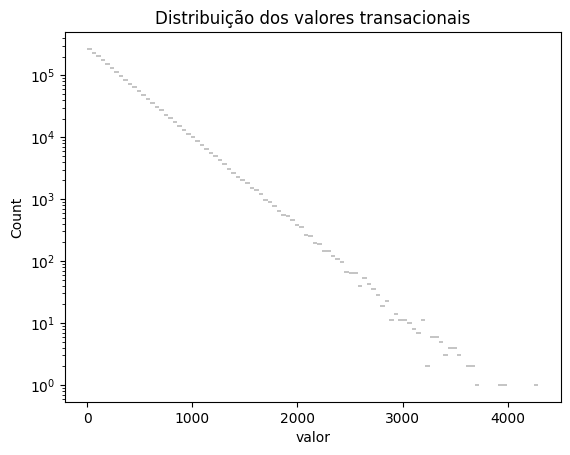

In [22]:
sns.histplot(df['valor'], bins=100, log_scale=(False, True))
plt.title("Distribuição dos valores transacionais")
plt.show()

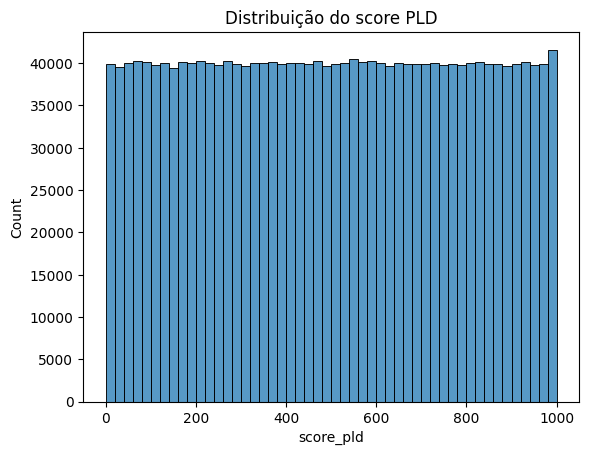

In [23]:
sns.histplot(df['score_pld'], bins=50)
plt.title("Distribuição do score PLD")
plt.show()

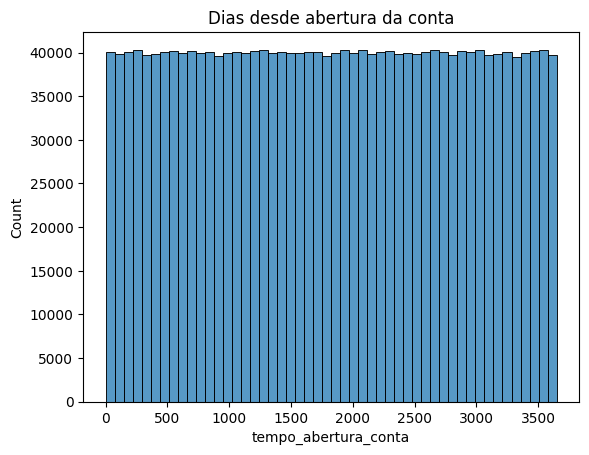

In [24]:
sns.histplot(df['tempo_abertura_conta'], bins=50)
plt.title("Dias desde abertura da conta")
plt.show()

3. Criação de novas variáveis

In [ ]:
df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['tempo_abertura_anos'] = df['tempo_abertura_conta'] / 365.0
df['log_valor'] = np.log1p(df['valor'])
df['score_pld_normalizado'] = df['score_pld'] / 1000.0
df['valor_acima_1000'] = (df['valor'] > 1000).astype(int)
df['canal_dispositivo'] = df['canal'] + "_" + df['tipo_dispositivo']
df['estado_categoria'] = df['estado'] + "_" + df['categoria_cliente']
df['valor_por_score'] = df['valor'] / (df['score_pld'] + 1)
df['valor_medio_diario'] = df['valor'] / (df['tempo_abertura_conta'] + 1)

limite_outlier = df['valor'].quantile(0.99)
df['valor_muito_alto'] = (df['valor'] > limite_outlier).astype(int)

df['score_categoria'] = df['categoria_cliente'] + "_" + pd.cut(
    df['score_pld'],
    bins=[0, 250, 500, 750, 1000],
    labels=["baixa", "média", "alta", "muito_alta"]
).astype(str)

df['manha'] = df['hora'].between(6, 11).astype(int)
df['madrugada'] = df['hora'].between(0, 5).astype(int)
df['horario_risco'] = df['manha'] + df['madrugada']

# Estados de fronteira (risco geográfico)
estados_fronteira = ["AC", "AM", "AP", "MS", "MT", "PA", "PR", "RO", "RR", "RS"]
df["estado_fronteira"] = df["estado"].isin(estados_fronteira).astype(int)

df["dia_util"] = df["dia_semana"].between(0, 4).astype(int)

media_score_estado = df.groupby("estado")["score_pld"].mean().to_dict()
df["media_score_estado"] = df["estado"].map(media_score_estado)

df["tipo_transacao"] = df["canal"] + "_" + df["categoria_cliente"]

df["hash_origem_destino"] = df["estado"] + "_" + df["estado"]

df = pd.concat([df, pd.get_dummies(df["regiao"], prefix="regiao")], axis=1)

4. Divisão em treino, validação e teste

In [ ]:
# Separação dados
treino = df[df['data_hora'] < "2024-08-01"].copy()
validacao = df[(df['data_hora'] >= "2024-08-01") & (df['data_hora'] < "2024-10-01")].copy()
teste = df[df['data_hora'] >= "2024-10-01"].copy()

# Tratamento de missings
treino.fillna(-1, inplace=True)
validacao.fillna(-1, inplace=True)
teste.fillna(-1, inplace=True)

In [57]:
output_dir = "../data/novas_features"
os.makedirs(output_dir, exist_ok=True)

treino.to_parquet(f"{output_dir}/treino.parquet", index=False)
validacao.to_parquet(f"{output_dir}/validacao.parquet", index=False)
teste.to_parquet(f"{output_dir}/teste.parquet", index=False)

5. Leitura dos dados e preparação

In [58]:
colunas_remover = ["id_transacao", "id_remetente", "id_destinatario", "data_hora", "dia_semana"]
target = "fraude"

X_train = pd.get_dummies(treino.drop(columns=colunas_remover + [target]), drop_first=True)
y_train = treino[target]

X_val = pd.get_dummies(validacao.drop(columns=colunas_remover + [target]), drop_first=True)
y_val = validacao[target]

X_test = pd.get_dummies(teste.drop(columns=colunas_remover + [target]), drop_first=True)
y_test = teste[target]

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.select_dtypes(include=[np.number])
X_val = X_val.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

6. scale_pos_weight

In [60]:
taxa_fraude = y_train.value_counts(normalize=True)
scale_pos_weight = (1 - taxa_fraude[1]) / taxa_fraude[1]
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 65.51


7. Treino modelo

In [61]:
from xgboost import XGBClassifier

In [62]:
n_neg = y_train[y_train == 0].shape[0]
n_pos = y_train[y_train == 1].shape[0]
scale_pos_weight = n_neg / n_pos

# Modelo com peso ajustado
modelo = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    max_depth=5,
    n_estimators=300,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
modelo.fit(X_train, y_train)

C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:09:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

8. Métricas + matriz de confusão


🔎 Métricas do Modelo:


,AUC,F1,Recall,Precision,Accuracy,MCC
Treino,0.6931,0.0475,0.6749,0.0246,0.5932,0.0660
Validação,0.5103,0.0300,0.4225,0.0155,0.5846,0.0024
Teste,0.4996,0.0287,0.4101,0.0149,0.5857,-0.0004


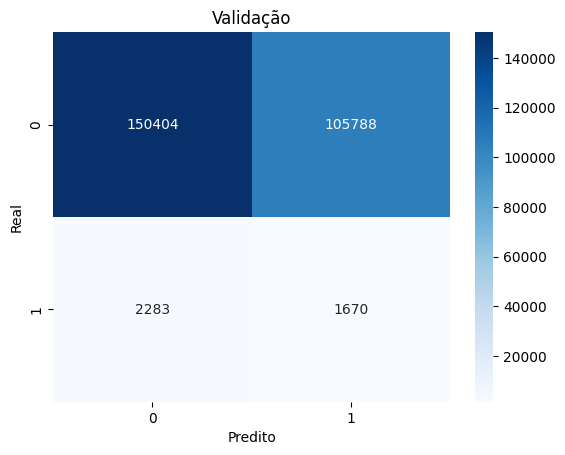

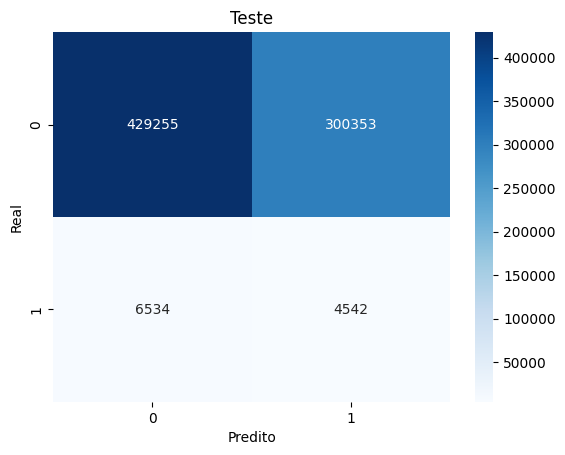

In [ ]:
def avaliar_completo(modelo, X, y):
    prob = modelo.predict_proba(X)[:, 1]
    pred = modelo.predict(X)
    return {
        "AUC": round(roc_auc_score(y, prob), 4),
        "F1": round(f1_score(y, pred), 4),
        "Recall": round(recall_score(y, pred), 4),
        "Precision": round(precision_score(y, pred), 4),
        "Accuracy": round(accuracy_score(y, pred), 4),
        "MCC": round(matthews_corrcoef(y, pred), 4),
    }

# Métricas
df_metricas = pd.DataFrame({
    "Treino": avaliar_completo(modelo, X_train, y_train),
    "Validação": avaliar_completo(modelo, X_val, y_val),
    "Teste": avaliar_completo(modelo, X_test, y_test),
}).T

print("\n🔎 Métricas do Modelo:")
display(df_metricas)

# Matriz
def matriz_confusao(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

matriz_confusao(y_val, modelo.predict(X_val), "Validação")
matriz_confusao(y_test, modelo.predict(X_test), "Teste")


9. Importância das variáveis

C:\Users\jessi\AppData\Local\Temp\ipykernel_7196\3195052103.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gain', y=df_importancias.index, data=df_importancias, palette="Blues_d")


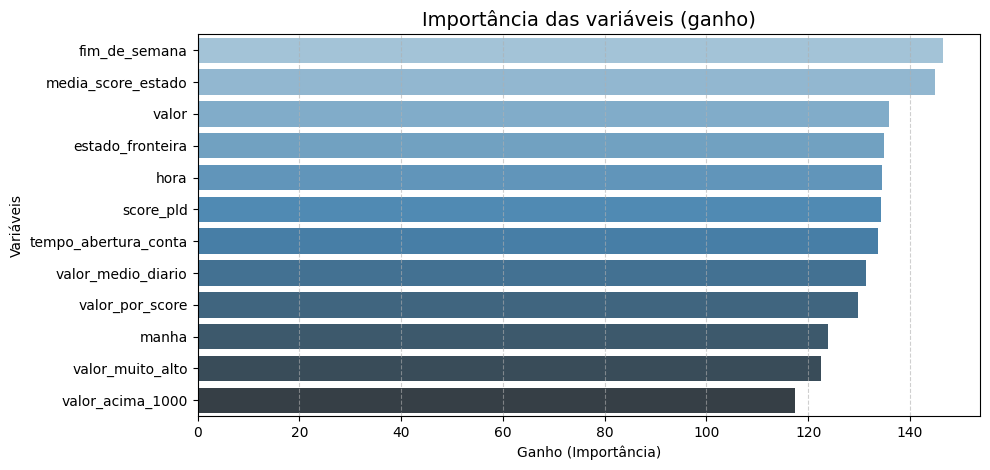

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importancias = modelo.get_booster().get_score(importance_type='gain')

df_importancias = pd.DataFrame.from_dict(importancias, orient='index', columns=['gain'])
df_importancias = df_importancias.sort_values(by='gain', ascending=False)
df_importancias['gain'] = df_importancias['gain'].round(2)

plt.figure(figsize=(10, df_importancias.shape[0] * 0.4))
sns.barplot(x='gain', y=df_importancias.index, data=df_importancias, palette="Blues_d")
plt.title("Importância das variáveis (ganho)", fontsize=14)
plt.xlabel("Ganho (Importância)")
plt.ylabel("Variáveis")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

10. Gráfico de distribuição dos scores por classe fraude

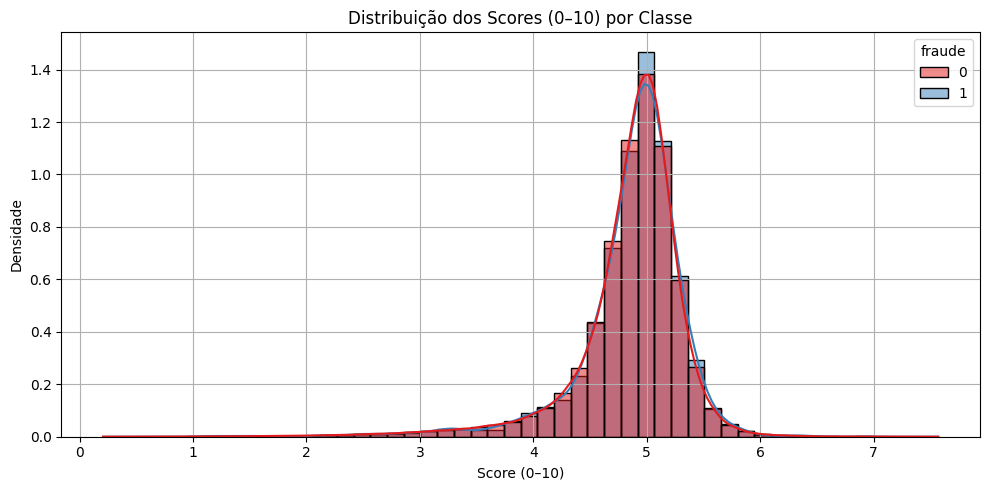

In [67]:
train_scores = modelo.predict_proba(X_train)[:, 1] * 10
val_scores = modelo.predict_proba(X_val)[:, 1] * 10
test_scores = modelo.predict_proba(X_test)[:, 1] * 10

df_val = pd.DataFrame({
    'score': val_scores,
    'fraude': y_val.values
})
plt.figure(figsize=(10, 5))
sns.histplot(data=df_val, x='score', hue='fraude', bins=50, stat="density", common_norm=False, palette='Set1', kde=True)
plt.title("Distribuição dos Scores (0–10) por Classe")
plt.xlabel("Score (0–10)")
plt.ylabel("Densidade")
plt.grid(True)
plt.tight_layout()
plt.show()

11.  Gráfico da Curva ROC

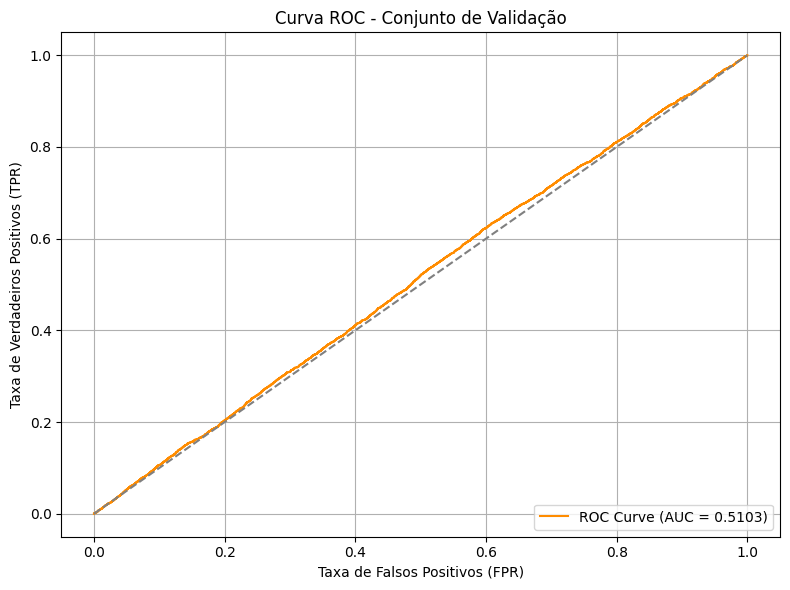

In [69]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, modelo.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Validação")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

10. Save modelo

In [72]:
import joblib
import os

os.makedirs("../modelos", exist_ok=True)
joblib.dump(modelo, "../modelos/modelo_fraude_pix.pkl")
joblib.dump(X_train.columns.tolist(), "../modelos/features_utilizadas.pkl")

print("Modelo e features salvos com sucesso:")
print("modelo_fraude_pix.pkl")
print("features_utilizadas.pkl")

Modelo e features salvos com sucesso:
modelo_fraude_pix.pkl
features_utilizadas.pkl
